<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/dynamic-ensemble-selection-in-python/)) <font size='3ptx'>**Dynamic ensemble selection is an ensemble learning technique that automatically selects a subset of ensemble members just-in-time when making a prediction.**</font>

The technique involves fitting multiple machine learning models on the training dataset, then selecting the models that are expected to perform best when making a prediction for a specific new example, based on the details of the example to be predicted.

**This can be achieved using a k-nearest neighbor model to locate examples in the training dataset that are closest to the new example to be predicted, evaluating all models in the pool on this neighborhood and using the models that perform the best on the neighborhood to make a prediction for the new example.**

As such, the dynamic ensemble selection can often perform better than any single model in the pool and better than averaging all members of the pool, so-called static ensemble selection.

In this tutorial, you will discover how to develop dynamic ensemble selection models in Python. After completing this tutorial, you will know:
* Dynamic ensemble selection algorithms automatically choose ensemble members when making a prediction on new data.
* How to develop and evaluate dynamic ensemble selection models for classification tasks using the scikit-learn API.
* How to explore the effect of dynamic ensemble selection model hyperparameters on classification accuracy.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Dynamic Ensemble Selection**](#sect1)</font>
* <font size='3ptx'>[**k-Nearest Neighbor Oracle (KNORA) With Scikit-Learn**](#sect2)</font>
  * [KNORA-Eliminate (KNORA-E)](#sect2_1)
  * [KNORA-Union (KNORA-U)](#sect2_2)
* <font size='3ptx'>[**Hyperparameter Tuning for KNORA**](#sect3)</font>
  * [Explore k in k-Nearest Neighbor](#sect3_1)
  * [Explore Algorithms for Classifier Pool](#sect3_2)

In [34]:
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU

<a id='sect1'></a>
## <font color='darkblue'>Dynamic Ensemble Selection</font> ([back](#sect0))
<font size='3ptx'>**Multiple Classifier Systems refer to a field of machine learning algorithms that use multiple models to address classification predictive modeling problems.**</font>

The first class of multiple classifier systems to find success is referred to as [**Dynamic Classifier Selection**](https://www.researchgate.net/publication/319632614_Dynamic_classifier_selection_Recent_advances_and_perspectives), or DCS for short.
* **Dynamic Classifier Selection:** Algorithms that dynamically choose one from among many trained models to make a prediction based on the specific details of the input.

**Dynamic Classifier Selection algorithms generally involve partitioning the input feature space in some way and assigning specific models to be responsible for making predictions for each partition.** There are a variety of different DCS algorithms and research efforts are mainly focused on how to evaluate and assign classifiers to specific regions of the input space.
> After training multiple individual learners, DCS dynamically selects one learner for each test instance. […] DCS makes predictions by using one individual learner. <br/><br/>
> [**— Page 93, Ensemble Methods: Foundations and Algorithms, 2012.**](https://amzn.to/32L1yWD)
<br/>

A natural extension to DCS is algorithms that select one or more models dynamically in order to make a prediction. That is, selecting a subset or ensemble of classifiers dynamically. These techniques are referred to as <font color='darkblue'>**dynamic ensemble selection, or DES**</font>.
* **Dynamic Ensemble Selection**: Algorithms that dynamically choose a subset of trained models to make a prediction based on the specific details of the input.

**Dynamic Ensemble Selection algorithms operate much like DCS algorithms, except predictions are made using votes from multiple classifier models instead of a single best model.** In effect, each region of the input feature space is owned by a subset of models that perform best in that region.
> … given the fact that selecting only one classifier can be highly error-prone, some researchers decided to select a subset of the pool of classifiers rather than just a single base classifier. All base classifiers that obtained a certain competence level are used to compose the EoC, and their outputs are aggregated to predict the label … <br/><br/>
> [**— Dynamic Classifier Selection: Recent Advances And Perspectives, 2018.**](https://www.sciencedirect.com/science/article/pii/S1566253517304074)

Perhaps the canonical approach to dynamic ensemble selection is the k-Nearest Neighbor Oracle, or [**KNORA**](https://arxiv.org/abs/1804.06943), algorithm as it is a natural extension of the canonical dynamic classifier selection algorithm “<font color='darkblue'>**Dynamic Classifier Selection Local Accuracy**</font>,” or DCS-LA.

DCS-LA involves selecting the k-nearest neighbors from the training or validation dataset for a given new input pattern, then selecting the single best classifier based on its performance in that neighborhood of k examples to make a prediction on the new example.

KNORA was described by Albert Ko, et al. in their 2008 paper titled “[**From Dynamic Classifier Selection To Dynamic Ensemble Selection**](https://dollar.biz.uiowa.edu/~street/ko07.pdf).” It is an extension of DCS-LA that selects multiple models that perform well on the neighborhood and whose predictions are then combined using majority voting to make a final output prediction.
> For any test data point, KNORA simply finds its nearest K neighbors in the validation set, figures out which classifiers correctly classify those neighbors in the validation set and uses them as the ensemble for classifying the given pattern in that test set. <br/><br/>
> [**— From Dynamic Classifier Selection To Dynamic Ensemble Selection, 2008.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320307004499)

**The selected classifier models are referred to as “<font color='darkblue'>oracles</font>“, hence the use of oracle in the name of the method.**

The ensemble is considered dynamic because the members are chosen just-in-time conditional on the specific input pattern requiring a prediction. This is opposed to static, where ensemble members are chosen once, such as averaging predictions from all classifiers in the model.
> This is done through a dynamic fashion, since different patterns might require different ensembles of classifiers. Thus, we call our method a dynamic ensemble selection. <br/><br/>
> [**— From Dynamic Classifier Selection To Dynamic Ensemble Selection, 2008.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320307004499)

Two versions of KNORA are described, including <font color='darkblue'>**KNORA-Eliminate**</font> and <font color='darkblue'>**KNORA-Union**</font>.
* **KNORA-Eliminate (KNORA-E)**: Ensemble of classifiers that achieves perfect accuracy on the neighborhood of the new example, with a reducing neighborhood size until at least one perfect classifier is located.
* **KNORA-Union (KNORA-U)**: Ensemble of all classifiers that makes at least one correct prediction on the neighborhood with weighted voting and votes proportional to accuracy on the neighborhood.

<font color='darkblue'>**KNORA-Eliminate**</font>, or <font color='darkblue'>**KNORA-E**</font> for short, involves selecting all classifiers that achieve perfect predictions on the neighborhood of k examples in the neighborhood. If no classifier achieves 100 percent accuracy, the neighborhood size is reduced by one and the models are re-evaluated. This process is repeated until one or more models are discovered that has perfect performance, and then used to make a prediction for the new example.
> In the case where no classifier can correctly classify all the K-nearest neighbors of the test pattern, then we simply decrease the value of K until at least one classifier correctly classifies its neighbors <br/><br/>
> [**— From Dynamic Classifier Selection To Dynamic Ensemble Selection, 2008.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320307004499)

<font color='darkblue'>**KNORA-Union**</font>, or <font color='darkblue'>**KNORA-U**</font> for short, involves selecting all classifiers that make at least one correct prediction in the neighborhood. The predictions from each classifier are then combined using a weighted average, where the number of correct predictions in the neighborhood indicates the number of votes assigned to each classifier.
> The more neighbors a classifier classifies correctly, the more votes this classifier will have for a test pattern <br/><br/>
> [**— From Dynamic Classifier Selection To Dynamic Ensemble Selection, 2008.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320307004499)

Now that we are familiar with DES and the KNORA algorithm, let’s look at how we can use it on our own classification predictive modeling projects.

<a id='sect2'></a>
## <font color='darkblue'>k-Nearest Neighbor Oracle (KNORA) With Scikit-Learn</font> ([back](#sect0))
<font size='3ptx'>**The Dynamic Ensemble Library, or [DESlib](https://github.com/scikit-learn-contrib/DESlib) for short, is a Python machine learning library that provides an implementation of many different dynamic classifiers and dynamic ensemble selection algorithms.**</font>

[**DESlib**](https://github.com/scikit-learn-contrib/DESlib) is an easy-to-use ensemble learning library focused on the implementation of the state-of-the-art techniques for dynamic classifier and ensemble selection. First, we can install the DESlib library using the pip package manager, if it is not already installed.

In [2]:
#!pip install deslib

Once installed, we can then check that the library was installed correctly and is ready to be used by loading the library and printing the installed version.

In [3]:
# check deslib version
import deslib
print(deslib.__version__)

0.3.5


Running the script will print your version of the DESlib library you have installed. Your version should be the same or higher than `0.3` in our case. If not, you must upgrade your version of the DESlib library.

The [**DESlib**](https://github.com/scikit-learn-contrib/DESlib) provides an implementation of the KNORA algorithm with each dynamic ensemble selection technique via the [**KNORAE**](https://deslib.readthedocs.io/en/latest/modules/des/knora_e.html) and [**KNORAU**](https://deslib.readthedocs.io/en/latest/modules/des/knora_u.html) classes respectively. Each class can be used as a scikit-learn model directly, allowing the full suite of scikit-learn data preparation, modeling pipelines, and model evaluation techniques to be used directly.

Both classes use a k-nearest neighbor algorithm to select the neighbor with a default value of `k=7`.

A [**bootstrap aggregation**](https://machinelearningmastery.com/bagging-ensemble-with-python/) (<font color='brown'>bagging</font>) ensemble of decision trees is used as the pool of classifier models considered for each classification that is made by default, although this can be changed by setting “<font color='violet'>pool_classifiers</font>” to a list of models.

We can use the [make_classification()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to create **a synthetic binary classification problem with 10,000 examples and 20 input features.**

In [5]:
# synthetic binary classification dataset

# define dataset
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=7
)

# summarize the dataset
print(X.shape, y.shape)

(10000, 20) (10000,)


Now that we are familiar with the [**DESlib API**](https://github.com/scikit-learn-contrib/DESlib), let’s look at how to use each KNORA algorithm on our synthetic classification dataset.

<a id='sect2_1'></a>
### <font color='darkgreen'>KNORA-Eliminate (KNORA-E)</font>
**We can evaluate a KNORA-Eliminate dynamic ensemble selection algorithm on the synthetic dataset.**

In this case, we will use default model hyperparameters, including bagged decision trees as the pool of classifier models and a `k=7` for the selection of the local neighborhood when making a prediction.

We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds:

In [8]:
# evaluate dynamic KNORA-E dynamic ensemble selection for binary classification

# define the model
model = KNORAE()

# define the evaluation procedure
cv = RepeatedStratifiedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=1
)

# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.913 (0.011)


In this case, we can see the KNORA-E ensemble and default hyperparameters achieve a classification accuracy of about 91.3 percent.

We can also use the KNORA-E ensemble as a final model and make predictions for classification. First, the model is fit on all available data, then the <font color='blue'>predict()</font> function can be called to make predictions on new data.

The example below demonstrates this on our binary classification dataset.

In [9]:
# define dataset
X, y = make_classification(
    n_samples=10000, 
    n_features=20, 
    n_informative=15,
    n_redundant=5, 
    random_state=7
)

# define the model
model = KNORAE()

# fit the model on the whole dataset
model.fit(X, y)

# make a single prediction
row = [
    0.2929949, -4.21223056, -1.288332, -2.17849815, -0.64527665,
    2.58097719, 0.28422388, -7.1827928,-1.91211104, 2.73729512,
    0.81395695, 3.96973717, -2.66939799,3.34692332, 4.19791821,
    0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808
]

yhat = model.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 0


Running the example fits the KNORA-E dynamic ensemble selection algorithm on the entire dataset and is then used to make a prediction on a new row of data, as we might when using the model in an application.

<a id='sect2_2'></a>
### <font color='darkgreen'>KNORA-Union (KNORA-U)</font>
**We can evaluate a KNORA-Union model on the synthetic dataset.**

In this case, we will use default model hyperparameters, including bagged decision trees as the pool of classifier models and a `k=7` for the selection of the local neighborhood when making a prediction.

We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

In [12]:
# define the model
model = KNORAU()

# define the evaluation procedure
cv = RepeatedStratifiedKFold(
    n_splits=10, 
    n_repeats=3, 
    random_state=1
)

# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.934 (0.010)


In this case, we can see the KNORA-U dynamic ensemble selection model and default hyperparameters achieve a classification accuracy of about 93.3 percent. Now that we are familiar with using the scikit-learn API to evaluate and use KNORA models, let’s look at configuring the model.

<a id='sect3'></a>
## <font color='darkblue'>Hyperparameter Tuning for KNORA</font>
<font size='3ptx'>**In this section, we will take a closer look at some of the hyperparameters you should consider tuning for the KNORA model and their effect on model performance.**</font>

There are many hyperparameters we can look at for KNORA, although **in this case, we will look at the value of `k` in the k-nearest neighbor model used in the local evaluation of the models, and how to use a custom pool of classifiers.**

We will use the KNORA-Union as the basis for these experiments, although the choice of the specific method is arbitrary.

<a id='sect3_1'></a>
### <font color='darkgreen'>Explore k in k-Nearest Neighbors</font>
**The configuration of the k-nearest neighbors algorithm is critical to the KNORA model as it defines the scope of the neighborhood in which each ensemble is considered for selection.**

The `k` value controls the size of the neighborhood and it is important to set it to a value that is appropriate for your dataset, specifically the density of samples in the feature space. A value too small will mean that relevant examples in the training set might be excluded from the neighborhood, whereas values too large may mean that the signal is being washed out by too many examples.

The code example below explores the classification accuracy of the KNORA-U algorithm with k values from 2 to 21.

In [16]:
%%time
# get the dataset
def get_dataset():
    X, y = make_classification(
        n_samples=10000, 
        n_features=20, 
        n_informative=15, 
        n_redundant=5,
        random_state=7
    )
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for n in range(2,22):
        models[str(n)] = KNORAU(k=n)
        
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(
        n_splits=10,
        n_repeats=3,
        random_state=1
    )
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# define dataset
X, y = get_dataset()

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>2 0.935 (0.008)
>3 0.937 (0.008)
>4 0.934 (0.009)
>5 0.934 (0.008)
>6 0.935 (0.009)
>7 0.936 (0.008)
>8 0.934 (0.007)
>9 0.934 (0.008)
>10 0.935 (0.008)
>11 0.938 (0.009)
>12 0.938 (0.009)
>13 0.936 (0.007)
>14 0.935 (0.008)
>15 0.935 (0.008)
>16 0.934 (0.009)
>17 0.934 (0.010)
>18 0.935 (0.007)
>19 0.936 (0.010)
>20 0.933 (0.010)
>21 0.935 (0.009)
Wall time: 1min 57s


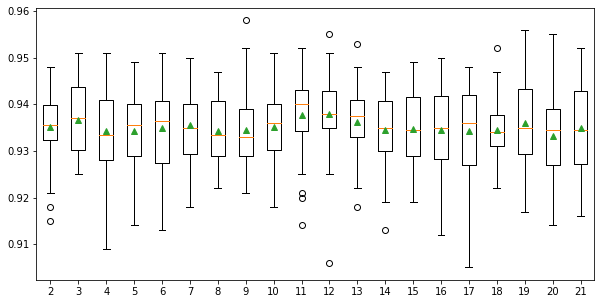

In [18]:
# plot model performance for comparison
plt.rcParams['figure.figsize'] = [10, 5]
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<a id='sect3_2'></a>
### <font color='darkgreen'>Explore Algorithms for Classifier Pool</font>
**The choice of algorithms used in the pool for the KNORA is another important hyperparameter.**

By default, [**bagged decision trees**](https://en.wikipedia.org/wiki/Bootstrap_aggregating) are used, as it has proven to be an effective approach on a range of classification tasks. Nevertheless, a custom pool of classifiers can be considered.
> In the majority of DS publications, the pool of classifiers is generated using either well known ensemble generation methods such as Bagging, or by using heterogeneous classifiers. <br/><br/>
> [**— Dynamic Classifier Selection: Recent Advances And Perspectives, 2018.**](https://www.sciencedirect.com/science/article/pii/S1566253517304074)

**This requires first defining a list of classifier models to use and fitting each on the training dataset. Unfortunately, this means that the automatic k-fold cross-validation model evaluation methods in scikit-learn cannot be used in this case**. Instead, we will use a train-test split so that we can fit the classifier pool manually on the training dataset.

The list of fit classifiers can then be specified to the <font color='darkblue'>**KNORA-Union**</font> (<font color='brown'>or</font> <font color='darkblue'>**KNORA-Eliminate**</font>) class via the “<font color='violet'>pool_classifiers</font>” argument. In this case, we will use a pool that includes logistic regression, a decision tree, and a naive Bayes classifier.

The complete example of evaluating the KNORA ensemble and a custom set of classifiers on the synthetic dataset is listed below:

In [35]:
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=7
)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# define classifiers to use in the pool
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
    SVC(),
    GradientBoostingClassifier(),
]

# fit each classifier on the training set
for c in classifiers:
    c.fit(X_train, y_train)

# define the KNORA-U model
model = KNORAU(pool_classifiers=classifiers)

# fit the model
model.fit(X_train, y_train)

# make predictions on the test set
yhat = model.predict(X_test)

# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score))

Accuracy: 0.956


In this case, we can see that the model achieved an accuracy of about 96.2 percent.

**In order to adopt the KNORA model, it must perform better than any contributing model**. Otherwise, we would simply use the contributing model that performs better. **We can check this by evaluating the performance of each contributing classifier on the test set.**

In [36]:
# evaluate contributing models
for c in classifiers:
    yhat = c.predict(X_test)
    score = accuracy_score(y_test, yhat)
    print('> %s: %.3f' % (c.__class__.__name__, score))

> LogisticRegression: 0.878
> DecisionTreeClassifier: 0.884
> GaussianNB: 0.873
> SVC: 0.982
> GradientBoostingClassifier: 0.942


Instead of specifying a pool of classifiers, it is also possible to specify a single ensemble algorithm from the scikit-learn library and the KNORA algorithm will automatically use the internal ensemble members as classifiers.

For example, we can use a random forest ensemble with 1,000 members as the base classifiers to consider within KNORA as follows:

In [39]:
# define classifiers to use in the pool
pool = RandomForestClassifier(n_estimators=1000)

# fit the classifiers on the training set
pool.fit(X_train, y_train)

# define the KNORA-U model
model = KNORAU(pool_classifiers=pool)

Tying this together, the complete example of KNORA-U with random forest ensemble members as classifiers is listed below.

In [40]:
# fit the model
model.fit(X_train, y_train)

# make predictions on the test set
yhat = model.predict(X_test)

# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score))

# evaluate the standalone model
yhat = pool.predict(X_test)
score = accuracy_score(y_test, yhat)
print('>%s: %.3f' % (pool.__class__.__name__, score))

Accuracy: 0.968
>RandomForestClassifier: 0.968


## <font color='darkblue'>Supplement</font> ([back](#sect0))
* [A Gentle Introduction to Mixture of Experts Ensembles](https://machinelearningmastery.com/mixture-of-experts/?fbclid=IwAR29lvTUiXQ-TVQtfnTtbj9FIRLAIsor16hBOohlLox0reLV6IZcVbEieho)